In [ ]:
import matplotlib as mpl
import matplotlib.animation
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib widget 
mpl.rc('image', cmap='gray')

import h5py 
import trackpy as tp
tp.quiet()

import joblib 

import numpy as np
import pandas as pd
import csv, json
import pims
from PIL import Image, ImageDraw
import cv2

from scipy.optimize import dual_annealing, linear_sum_assignment
from scipy.spatial import distance_matrix
from tqdm import tqdm
import random

import skimage
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois

np.random.seed(6)
lbl_cmap = random_label_cmap()
# initialize model with versatile fluorescence pretrained weights
model = StarDist2D.from_pretrained('2D_versatile_fluo')
print(model)

run_preprocessing_verb = False

In [ ]:
def get_data_preload(startFrame, endFrame, data_preload_path, dataset_name):
    with h5py.File(data_preload_path, 'r') as f:
        dataset = f[dataset_name]
        frameImg = dataset[startFrame:endFrame]
    return frameImg

@pims.pipeline
def preprocessing(image, w, h, x1, y1, x2, y2):
    """
    Preprocessing function for the data.

    Parameters
    ----------
    image : pims.Frame
        Frame of the video.
    x1 : int
        x coordinate of the top left corner of the ROI. (region of interest)
    y1 : int
        y coordinate of the top left corner of the ROI.
    x2 : int    
        x coordinate of the bottom right corner of the ROI.
    y2 : int    
        y coordinate of the bottom right corner of the ROI.

    Returns
    -------
    npImage : np.array
        Preprocessed image.
    """
    npImage = np.array(image)
    alpha = Image.new('L', (h, w), 0)
    draw = ImageDraw.Draw(alpha)
    draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)
    npAlpha = np.array(alpha)
    npImage = cv2.cvtColor(npImage, cv2.COLOR_BGR2GRAY)*npAlpha
    ind = np.where(npImage == 0)
    npImage[ind] = npImage[200, 200]
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    # sharpen image https://en.wikipedia.org/wiki/Kernel_(image_processing)
    image_sharp = cv2.filter2D(src=npImage, ddepth=-1, kernel=kernel)
    return image_sharp

In [ ]:
parameters = pd.read_csv('./setup_file.csv')
display(parameters)

video_selection   = parameters["video_selection"][0]
system_name       = f"{video_selection} system"
source_path       = parameters["source_path"][0]
part              = parameters["part"][0]
range_frames       = np.arange(10**5*(part-1), 10**5*part, 1, dtype = int)
start_frame = parameters["start_frame"][0]
end_frame   = parameters["end_frame"][0]
if start_frame not in range_frames or end_frame-1 not in range_frames:
    raise ValueError(f"start_frame and end_frame must be in range {range_frames[0]}-{range_frames[-1]+1} since part = {part}")
save_path         = parameters["save_path"][0] # 
data_preload_path = parameters["data_preload_path"][0] + "part2.h5"

xmin = parameters["xmin"][0]
ymin = parameters["ymin"][0]
xmax = parameters["xmax"][0]
ymax = parameters["ymax"][0]
rmax = parameters["rmax"][0]
rmin = parameters["rmin"][0]

start_frame = parameters["start_frame"][0]
end_frame   = parameters["end_frame"][0]
nDrops      = parameters["nDrops"][0]

original_video = pims.open(source_path)
fps = int(original_video.frame_rate)
data_type = original_video.pixel_type
w = original_video.frame_shape[1]
h = original_video.frame_shape[0]

preprocessed_video = preprocessing(original_video, h, w, xmin, ymin, xmax, ymax) 
frames = np.arange(start_frame, end_frame, 1, dtype=int)

In [ ]:
try: 
    test = get_data_preload(0, 1, data_preload_path, "dataset_name")
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.imshow(test[0])
    plt.show()
    print("Data already ready as h5 file")
except:
    print("Data needs to be written as h5 file first:")
    hdf = h5py.File(data_preload_path, "a")
    dset = hdf.create_dataset(name = "dataset_name", shape = (0, h, w),
                              maxshape = (None, h, w), dtype = data_type)
    for frame in tqdm(range_frames):
        dset.resize(dset.shape[0] + 1, axis=0)
        new_data = preprocessed_video[frame]
        dset[-1:] = new_data
    hdf.close()
    pd.DataFrame(frames).to_csv(f"/Volumes/ExtremeSSD/UNI/THESIS/h5_data_thesis/25b-25r/frames_part{part}.csv", index=False)

# FEATURE LOCATION PIPELINE

In [ ]:
def test_setup(n_of_samples, frames):
    droplets_found = []
    area = []
    frames_sample = np.sort(np.random.choice(np.arange(0, len(frames), 1, dtype=int), n_of_samples, replace=False))
    img = get_data_preload(frames_sample[0], frames_sample[0] + 1, data_preload_path, 'dataset_name')[0]      

    labels_test, dict_test = model.predict_instances(normalize(img), predict_kwargs = {'verbose':False}) 
    test = skimage.measure.regionprops_table(labels_test, properties=('centroid', 'area'))

    fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 6), sharex=True, sharey=True)
    coord, points, prob = dict_test['coord'], dict_test['points'], dict_test['prob']
    ax.imshow(img, cmap='gray'); 
    ax.set(title = 'Preprocessed Image', xlabel='X [px]', ylabel='Y [px]')
    ax1.imshow(img, cmap='gray'); 
    _draw_polygons(coord, points, prob, show_dist=True)
    ax1.set(title = f"Stardist result", xlabel='X [px]', ylabel='Y [px]')
    plt.suptitle(f"Stardist result on frame {frames_sample[0] + frames[0]}")
    plt.tight_layout()
    #ax.set(xlim=(462, 510), ylim = (280, 330))
    plt.savefig(save_path + f'stardist_example_part{part}.pdf', format='pdf')
    plt.close()

    print(f"testing setup on {n_of_samples} samples...")
    for frame in tqdm(frames_sample):
        img = get_data_preload(frame, frame + 1, data_preload_path, 'dataset_name')[0]
        labels_test, dict_test = model.predict_instances(normalize(img), predict_kwargs = {'verbose':False}) 
        droplets_found.append(dict_test['coord'].shape[0])
        test = skimage.measure.regionprops_table(labels_test, properties=('centroid', 'area'))
        area += list(test['area'])

    print(f"Average number of droplets found: {np.mean(droplets_found)}")
    print(f"N of times droplets > {nDrops}: {np.sum(np.array(droplets_found) > nDrops)} / {n_of_samples} ")
    print(f"N of times droplets < {nDrops}: {np.sum(np.array(droplets_found) < nDrops)} / {n_of_samples}")
    print(f"Average radius of droplets found: {np.mean(np.sqrt(area)/np.sqrt(np.pi))}")

    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    ax.plot(np.sqrt(area)/np.sqrt(np.pi))
    ax.set(ylabel='Radius [px]', title='Radius of droplets found')
    ax1.plot(frames_sample, droplets_found)
    ax.set(ylabel='Radius [px]', title='Radius of droplets found')
    plt.savefig(save_path + f'test_setup_part{part}.pdf', format='pdf')
    plt.close()

In [ ]:
test_setup(100, frames)

In [ ]:
if 1:
    print("Initialize model with versatile fluorescence pretrained weights...")
    model = StarDist2D.from_pretrained('2D_versatile_fluo')
    print(model)
    print("Starting location process...") 
    area, x, y, prob, framesList = [], [], [], [], []
    for frame in tqdm(frames[:10000] - frames[0]):
        img = get_data_preload(frame, frame + 1, data_preload_path, 'dataset_name')[0]
        segmented_image, dict_test = model.predict_instances(normalize(img), \
                                                             predict_kwargs = {'verbose':False})
        test = skimage.measure.regionprops_table(segmented_image, properties=('centroid', 'area'))

        area   += list(test['area'])
        y      += list(test['centroid-0'])
        x      += list(test['centroid-1'])
        prob   += list(dict_test['prob'])
        framesList += list(np.ones(len(list(test['centroid-0'])))*(frame+frames[0]))
    # save data
    print("Saving data...")
    df = pd.DataFrame({'x':x, 'y':y, 'area':area, 'prob':prob, 'frame':framesList})
    df['frame'] = df.frame.astype('int')
    df['r'] = np.sqrt(df.area/np.pi)
    df.sort_values(by=['frame', 'prob'], ascending=[True, False], inplace=True)
    df.to_parquet(save_path + f'df_part{part}_.parquet')
else:
    df = pd.read_parquet(save_path + 'raw_trajectories.parquet')
    display(df.head())

In [5]:
df = pd.read_parquet(save_path + 'df.parquet')
display(df)

,x,y,area,prob,frame,r
0,394.892857,303.435714,280,0.925727,100000,9.440697
1,366.681818,290.397727,264,0.920260,100000,9.166996
2,397.621324,271.658088,272,0.917052,100000,9.304853
3,210.581749,321.498099,263,0.906058,100000,9.149617
4,389.633962,154.766038,265,0.905037,100000,9.184341
...,...,...,...,...,...,...
514187,240.526104,293.469880,249,0.849903,109999,8.902761
514188,351.609053,316.041152,243,0.849394,109999,8.794845
514189,224.071146,301.418972,253,0.849198,109999,8.973985
514190,391.192913,327.165354,254,0.849157,109999,8.991702


# POST PROCESSING OF FEATURE LOCATION 

,x,y,area,prob,frame,r
0,394.892857,303.435714,280,0.925727,100000,9.440697
1,366.681818,290.397727,264,0.920260,100000,9.166996
2,397.621324,271.658088,272,0.917052,100000,9.304853
3,210.581749,321.498099,263,0.906058,100000,9.149617
4,389.633962,154.766038,265,0.905037,100000,9.184341


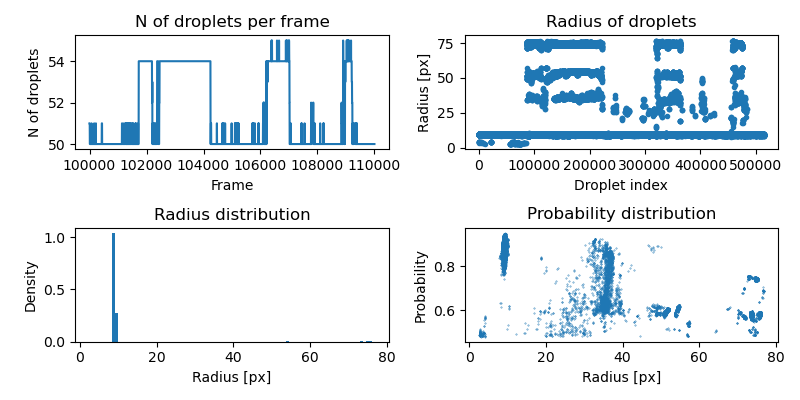

In [8]:
#df = pd.read_parquet(save_path + 'raw_trajectories.parquet')
display(df.head())
fig, ax = plt.subplots(2, 2, figsize=(8, 4))
ax[0, 0].plot(df.frame.unique(), df.groupby('frame').count().x.values)
ax[0, 0].set(xlabel='Frame', ylabel='N of droplets', title='N of droplets per frame')
ax[0, 1].plot(df.r, '.')
ax[0, 1].set(xlabel='Droplet index', ylabel='Radius [px]', title='Radius of droplets')
ax[1, 0].hist(df.r, bins=100, density=True)
ax[1, 0].set(xlabel='Radius [px]', ylabel='Density', title='Radius distribution')
ax[1, 1].scatter(df.r, df.prob, s=0.1)
ax[1, 1].set(xlabel='Radius [px]', ylabel='Probability', title='Probability distribution')
plt.tight_layout()
plt.show()

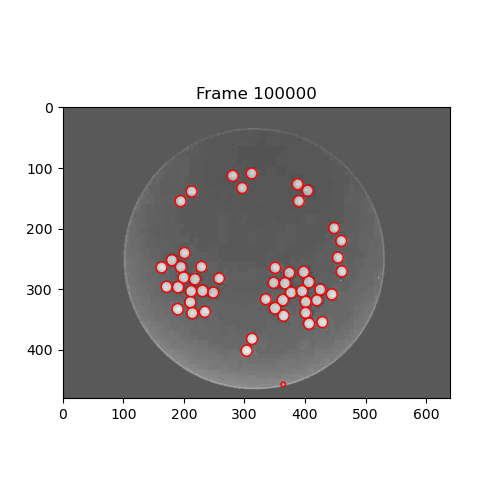

In [10]:
selected_frame = np.where(df.groupby('frame').count().x.values!=nDrops)[0][0] + df.frame.min()
img = get_data_preload(selected_frame-df.frame.min(), selected_frame-df.frame.min()+1, data_preload_path, 'dataset_name').reshape(h, w)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title(f"Frame {selected_frame}")
ax.imshow(img, cmap='gray')
for i in range(len(df.loc[df.frame == selected_frame])):
    ax.add_artist(plt.Circle((df.loc[df.frame == selected_frame].x.values[i], df.loc[df.frame == selected_frame].y.values[i]), \
                                df.loc[df.frame == selected_frame].r.values[i], color='r', fill=False))
plt.show()

In [11]:
rmax = 12
rmin = 6

frames: 10000 errors: 0


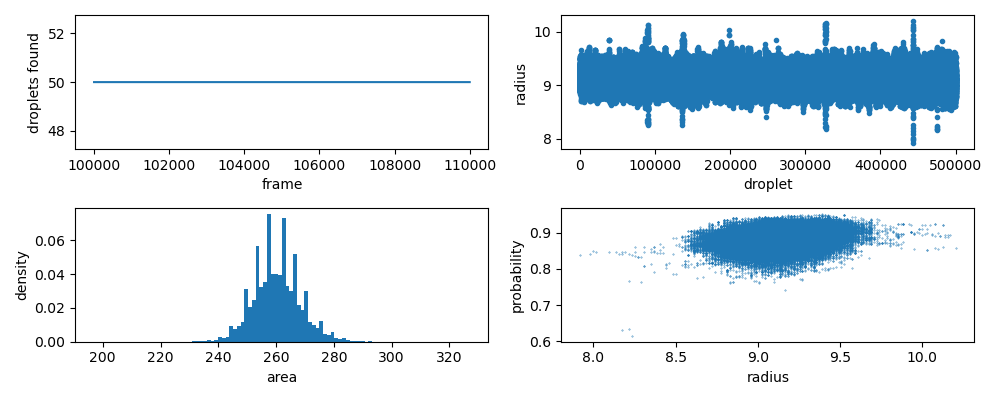

In [12]:
# filter found features
if 1:
    filtered_df = df.loc[df.r.between(rmin, rmax)]
    filtered_df = filtered_df.groupby('frame').apply(lambda x: x.nlargest(nDrops, 'prob'))
    filtered_df = filtered_df.reset_index(drop=True)

print("frames:", len(filtered_df.frame.unique()), "errors:", len(np.where(filtered_df.groupby('frame').count().x.values != nDrops)[0]))
fig, ax = plt.subplots(2, 2, figsize=(10, 4))
ax[0, 0].plot(filtered_df.frame.unique(), filtered_df.groupby('frame').count().x.values)
ax[0, 0].set(xlabel='frame', ylabel='droplets found')
ax[0, 1].plot(filtered_df.r, '.')
ax[0, 1].set(xlabel='droplet', ylabel='radius')
ax[1, 0].hist(filtered_df.area, bins=100, density=True)
ax[1, 0].set(xlabel='area', ylabel='density')
ax[1, 1].scatter(filtered_df.r, filtered_df.prob, s=0.1)
ax[1, 1].set(xlabel='radius', ylabel='probability')
plt.tight_layout()
plt.show()

In [ ]:
err_frames = np.where(filtered_df.groupby('frame').count().x != nDrops)[0] + filtered_df.frame.min()
if len(err_frames) > 0:
    err_frame_select = np.random.choice(err_frames, 1)[0]
    img = get_data_preload(err_frame_select-df.frame.min(), err_frame_select-df.frame.min()+1, data_preload_path, 'dataset_name').reshape(h, w)

    print(len(err_frames), err_frames)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.set_title(f"Frame {err_frame_select}")
    ax.imshow(img, cmap='gray')
    for i in range(len(filtered_df.loc[filtered_df.frame == err_frame_select])):
        ax.add_artist(plt.Circle((filtered_df.loc[filtered_df.frame == err_frame_select].x.values[i],\
                                filtered_df.loc[filtered_df.frame == err_frame_select].y.values[i]), \
                                filtered_df.loc[filtered_df.frame == err_frame_select].r.values[i], color='r', fill=False))
    plt.show()

[108858]


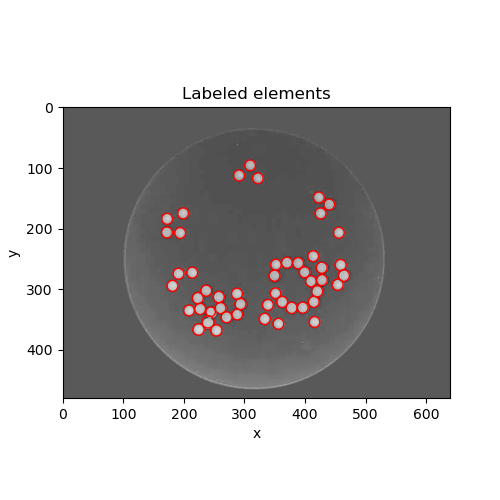

In [15]:
mmmeh_frames = filtered_df.loc[filtered_df.r == filtered_df.r.max()].frame.unique()
print(mmmeh_frames)
frame = mmmeh_frames[0]
df_plot = filtered_df.loc[filtered_df.frame == frame]

img = get_data_preload(frame-filtered_df.frame.min(), frame-filtered_df.frame.min()+1, data_preload_path, 'dataset_name').reshape(h, w)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(img, cmap='gray')
for i in range(len(df_plot)):
    ax.add_artist(plt.Circle((df_plot.x.values[i], df_plot.y.values[i]), df_plot.r.values[i], color='r', fill=False))
ax.set(title='Labeled elements', xlabel='x', ylabel='y')
plt.show()

# PRODUCTION OF TRAJECTORIES FROM REFINED FEATURE LOCATION DATA

In [ ]:
# Function to interpolate missing values for each group
interp_method = "quadratic"
def interpolate_trajectory(group):
    all_frames = pd.DataFrame({"frame": range(group["frame"].min(), group["frame"].max() + 1)})
    merged = pd.merge(all_frames, group, on="frame", how="left")
    merged.sort_values(by="frame", inplace=True)
    # Interpolate missing values
    merged["x"] = merged["x"].interpolate(method = interp_method)
    merged["y"] = merged["y"].interpolate(method = interp_method)
    merged["r"] = merged["r"].interpolate(method = interp_method)
    merged["area"] = merged["area"].interpolate(method = interp_method)
    merged["prob"] = merged["prob"].interpolate(method = interp_method)
    merged["frame"] = merged["frame"].interpolate(method = interp_method)
    merged["particle"].ffill(inplace=True)
    merged["color"].ffill(inplace=True)
    return merged

In [ ]:
#############################################################################################################
#                                         LINK FEATURES WITH TRACKPY                                        #
#############################################################################################################
if 0:
    cutoff = 100
    mem = 5
    t = tp.link_df(df, cutoff, memory = mem, link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)
    #print(t)
    t = t.sort_values(['frame', 'particle'])

    # filter out short trajectories (less than 25 frames)
    t_filtered = tp.filter_stubs(t, 25)

    # CREATE COLOR COLUMN AND SAVE DF
    n = max(t_filtered.particle)
    print(f"N of droplets: { n + 1}")
    random.seed(5)
    colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
    for i in range(max(t_filtered.particle)+1-n):
        colors.append("#00FFFF")
    c = []
    for p in t.particle:
        c.append(colors[p])
    t["color"] = c
    #t.to_parquet(save_path + f'df_linked_raw_part{part}.parquet', index=False)

    missing_droplets = {}
    confront_array = np.arange(nDrops)
    for err_frame in err_frames:
        frame_df = t.loc[t.frame == err_frame]
        missing_droplets[err_frame] = np.setdiff1d(confront_array, frame_df.particle.values)[0]
    print(missing_droplets)
    missing_droplets_df = pd.DataFrame.from_dict(missing_droplets, orient='index', columns=['particle'])
    missing_droplets_df['frame'] = missing_droplets_df.index
    missing_droplets_df.reset_index(drop = True, inplace = True)
    #missing_droplets_df.to_parquet(save_path + f'missing_droplets_part{part}.parquet', index=False)

    # fill missing positions, radii, areas and probabilities with interpolation (polynomial order 3)
    trajectories = t.groupby("particle").apply(interpolate_trajectory)
    # Reset the index of the filled dataframe
    trajectories.reset_index(drop=True, inplace=True)
    trajectories["particle"] = trajectories["particle"].astype(int)
    #trajectories.to_parquet(save_path + f'df_linked_part{part}_interpolated.parquet', index=False)
else:
    t = pd.read_parquet(save_path + 'df_linked_raw.parquet')
    trajectories = pd.read_parquet(save_path + 'df_linked.parquet')
    missing_droplets = pd.read_parquet(save_path + 'missing_droplets.parquet')
    print(f"Number of error frames: {len(missing_droplets)}")

In [ ]:
trajectories = t.groupby("particle").apply(interpolate_trajectory)
# Reset the index of the filled dataframe
trajectories.reset_index(drop=True, inplace=True)

In [ ]:
"""
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(t.groupby("frame").size(), color = "k", label = "n of droplets")
ax.axhline(nDrops, color = "r", linestyle = "--", label = "correct n")
ax.set(xlabel = "frame", ylabel = "n")
ax.set_title("Number of droplets per frame - pre interpolation")
ax.grid(linewidth = 0.2)
ax.legend()
#plt.savefig(save_path + 'n_of_droplets_raw.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(trajectories.groupby("frame").size(), color = "k", label = "n of droplets")
ax.axhline(nDrops, color = "r", linestyle = "--", label = "correct n")
ax.set(xlabel = "frame", ylabel = "n")
ax.set_title("Number of droplets per frame - after interpolation")
ax.grid(linewidth = 0.2)
ax.legend()
#plt.savefig(save_path + 'n_of_droplets.png', bbox_inches='tight')
plt.show()
"""

# example of interpolation
val = 3
raw = t.loc[(t.frame.between(missing_droplets.frame.values[val]-10, missing_droplets.frame.values[val]+10)) & (t.particle == missing_droplets.particle.values[val])]
interpolated = trajectories.loc[(trajectories.frame.between(missing_droplets.frame.values[val]-10, missing_droplets.frame.values[val]+10)) & (trajectories.particle == missing_droplets.particle.values[val])]
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)
ax.plot(raw.x, raw.y, '--bo')
ax1.plot(interpolated.x, interpolated.y, '--ro')
ax.set(title='Raw trajectory', xlabel = 'X [px]', ylabel = 'Y [px]')
ax1.set(title='Interpolated trajectory', xlabel = 'X [px]', ylabel = 'Y [px]')
plt.savefig(save_path + 'interpolation_example.png', bbox_inches='tight')
ax.grid(linewidth = 0.2)
ax1.grid(linewidth = 0.2)
plt.show()

In [ ]:
fig = plt.figure(figsize = (5, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(frame):
    df = trajectory.loc[(trajectory.frame == frame) , ["x", "y", "color", "r"]]
    for i in range(len(df)):
        graph[i].center = (df.x.values[i], df.y.values[i])
        graph[i].radius = df.r.values[i]
    graph2.set_data(preprocessed_data[frame-trajectory.frame.min()])
    title.set_text('Tracking raw - frame = {}'.format(frame))
    return graph

ax = fig.add_subplot(111)
title = ax.set_title('Tracking stardist + trackpy - frame = 0')
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]')
df = trajectory.loc[(trajectory.frame == trajectory.frame.min()), ["x", "y", "color", "r"]]

graph = []
for i in range(len(df)):
    graph.append(ax.add_artist(plt.Circle((df.x.values[i], df.y.values[i]), df.r.values[i], color = df.color.values[i],\
                                           fill = False, linewidth=1)))
graph2 = ax.imshow(preprocessed_data[0])

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, range(trajectory.frame.min(), trajectory.frame.max(), 1), interval = 5, blit=False)
if 1: 
    writer = matplotlib.animation.FFMpegWriter(fps = 30, metadata = dict(artist='Matteo Scandola'), extra_args=['-vcodec', 'libx264'])
    ani.save(save_path + 'tracking.mp4', writer=writer, dpi = 300)
plt.close()

In [ ]:
filtered_df = pd.read_parquet(save_path + 'df_linked_raw.parquet')
fig, ax = plt.subplots(2, 2, figsize=(10, 4))
ax[0, 0].plot(filtered_df.frame.unique(), filtered_df.groupby('frame').count().x.values)
ax[0, 0].set(xlabel='frame', ylabel='droplets found')
ax[0, 1].plot(filtered_df.r, '.')
ax[0, 1].set(xlabel='droplet', ylabel='radius')
ax[1, 0].hist(filtered_df.area, bins=100, density=True)
ax[1, 0].set(xlabel='area', ylabel='density')
ax[1, 1].scatter(filtered_df.r, filtered_df.prob, s=0.1)
ax[1, 1].set(xlabel='radius', ylabel='probability')
plt.tight_layout()
plt.show()

In [ ]:
filtered_df = pd.read_parquet(save_path + 'df_linked.parquet')
fig, ax = plt.subplots(2, 2, figsize=(10, 4))
ax[0, 0].plot(filtered_df.frame.unique(), filtered_df.groupby('frame').count().x.values)
ax[0, 0].set(xlabel='frame', ylabel='droplets found')
ax[0, 1].plot(filtered_df.r, '.')
ax[0, 1].set(xlabel='droplet', ylabel='radius')
ax[1, 0].hist(filtered_df.area, bins=100, density=True)
ax[1, 0].set(xlabel='area', ylabel='density')
ax[1, 1].scatter(filtered_df.r, filtered_df.prob, s=0.1)
ax[1, 1].set(xlabel='radius', ylabel='probability')
plt.tight_layout()
plt.show()